In [ ]:
import sys,os
import h5py
import numpy as np
import pandas as pd
from datetime import datetime

module_path = os.path.abspath(os.path.join('..'))
# module_path = os.path.join(os.path.abspath(os.path.join('..')),'wgpack')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
from wgpack.config import RDRPATH,seachest_data_dir
from wgpack.adcp import readADCP_raw,motion_correct_ADCP_gps_h5py,Doppler_vel_ADCP_h5py
from wgpack.timeconv import datetime2matlabdn
from wgpack.nav import get_bearing
from wgpack.helperfun import nan_interpolate

vnam = 'sv3-1101'
datedir = '20220227_20220309'


In [ ]:
# from wgpack.helperfun import movingaverage,nan_interpolate

# def Doppler_vel_ADCP_h5py(adcpr, mag_dec=None, qc_flg=False):
#     '''
#     This function transforms Wave Glider ADCP beam velocities into an Earth reaference frame.
#     :param adcpr: output file from rdradcp.m (.mat file read using h5py)
#     :param mag_dec: 
#     :param qc_flg: 
#     :return: dictionary containing ADCP Doppler velocities and auxiliary variables
#     '''
#     import datetime
#     import pyproj
#     import numpy as np
#     import pandas as pd
#     # Collect variables:
#     # time
#     mtime = np.array(adcpr['nav_mtime'][:-1]).flatten()  #
#     # convert matlab datenum to datetime
#     nav_time = []
#     for mt in mtime:
#         nav_time.append(datetime.datetime.fromordinal(int(mt))
#                         + datetime.timedelta(days=mt % 1)
#                         - datetime.timedelta(days=366))
#     # convert to pandas datetime
#     nav_time = pd.to_datetime(nav_time)
#     kk = len(nav_time)
#     # nav variables
#     pitch = np.array(adcpr['pitch'][:kk]).flatten()  #
#     roll = np.array(adcpr['roll'][:kk]).flatten()  #
#     heading = np.array(adcpr['heading'][:kk]).flatten()  #
#     nav_elongitude = np.array(adcpr['nav_elongitude'][:kk]).flatten()  #
#     nav_elatitude = np.array(adcpr['nav_elatitude'][:kk]).flatten()  #
#     # Bottom tracking
#     bt_range = np.array(adcpr['bt_range'])[:kk, :].T  #
#     bt_range_mean = np.mean(bt_range, axis=0)
#     # Doppler velocities (beam)
#     b1_vel = np.array(adcpr['east_vel'])[:kk, :].T  #
#     b2_vel = np.array(adcpr['north_vel'])[:kk, :].T  #
#     b3_vel = np.array(adcpr['vert_vel'])[:kk, :].T  #
#     b4_vel = np.array(adcpr['error_vel'])[:kk, :].T  #
#     # QC variables
#     perc_good = np.array(adcpr['perc_good'])[:kk, :, :].T  #
#     corr = np.array(adcpr['corr'])[:kk, :, :].T  #
#     intens = np.array(adcpr['intens'])[:kk, :, :].T  #
#     # config variables
#     ranges = np.array(adcpr['config']['ranges']).flatten()
#     beam_angle = float(adcpr['config']['beam_angle'][:])  #
#     EA = float(adcpr['config']['xducer_misalign'][:])  #
#     EB = float(adcpr['config']['magnetic_var'][:])  #
#     xmit_pulse = float(adcpr['config']['xmit_pulse'][:])  #
#     xmit_lag = float(adcpr['config']['xmit_lag'][:])  #
#     # Magnetic declination correction (necessary when EB is configured incorrectly)
#     if mag_dec is None:
#         pass
#     else:
#         heading = (heading - EB + mag_dec) % 360

    
#     # ------------------------------------------------------------
#     # Q/C ADCP velocities
#     # ------------------------------------------------------------
#     # Note that percent-good (perc_good < 100) already masks velocity data with nans
#     if qc_flg:
#         # Along-beam velocities are rejected for instrument tilts greater than 20 deg
#         tilt_THRESH = 20
#         # pitch
#         b1_vel[:,np.abs(pitch>tilt_THRESH)] = np.nan
#         b2_vel[:,np.abs(pitch>tilt_THRESH)] = np.nan
#         b3_vel[:,np.abs(pitch>tilt_THRESH)] = np.nan
#         b4_vel[:,np.abs(pitch>tilt_THRESH)] = np.nan
#         # roll
#         b1_vel[:,np.abs(roll>tilt_THRESH)] = np.nan
#         b2_vel[:,np.abs(roll>tilt_THRESH)] = np.nan
#         b3_vel[:,np.abs(roll>tilt_THRESH)] = np.nan
#         b4_vel[:,np.abs(roll>tilt_THRESH)] = np.nan
#         # Along-beam velocities are rejected for along beam correlations below 90 counts
#         corr_THRESH = 80
#         b1_vel[corr[:,0,:]<corr_THRESH] = np.nan
#         b2_vel[corr[:,1,:]<corr_THRESH] = np.nan
#         b3_vel[corr[:,2,:]<corr_THRESH] = np.nan
#         b4_vel[corr[:,3,:]<corr_THRESH] = np.nan
#         # Along-beam velocities are rejected for along beam correlations below 90 counts
#         intens_THRESH = 50
#         b1_vel[intens[:,0,:]<intens_THRESH] = np.nan
#         b2_vel[intens[:,1,:]<intens_THRESH] = np.nan
#         b3_vel[intens[:,2,:]<intens_THRESH] = np.nan
#         b4_vel[intens[:,3,:]<intens_THRESH] = np.nan

#     # ------------------------------------------------------------
#     # Process ADCP velocities
#     # ------------------------------------------------------------
#     # Beam to Instrument
#     # Constants
#     c = 1
#     theta = np.deg2rad(beam_angle)  # beam angle
#     a = 1 / (2 * np.sin(theta))
#     b = 1 / (4 * np.cos(theta))
#     d = a / np.sqrt(2)
#     # instrument velocities
#     x_vel = c * a * (b1_vel - b2_vel)
#     y_vel = c * a * (b4_vel - b3_vel)
#     z_vel = b * (b1_vel + b2_vel + b3_vel + b4_vel)
#     err_vel = d * (b1_vel + b2_vel - b3_vel - b4_vel)
#     # ------------------------------------------------------------
#     # Instrument to Ship
#     h = -EA
#     ch = np.cos(np.deg2rad(h))
#     sh = np.sin(np.deg2rad(h))
#     cp = np.cos(np.deg2rad(pitch))
#     sp = np.sin(np.deg2rad(pitch))
#     cr = np.cos(np.deg2rad(roll))
#     sr = np.sin(np.deg2rad(roll))
#     # From Teledyne ADCP Coordinate Transformation, Formulas and Calculations
#     u = (ch * cr + sh * sp * sr) * x_vel + (sh * cp) * y_vel + (ch * sr - sh * sp * cr) * z_vel
#     v = (-sh * cr + ch * sp * sr) * x_vel + (ch * cp) * y_vel + (-sh * sr - ch * sp * cr) * z_vel
#     w = (-cp * sr) * x_vel + (sp) * y_vel + (cp * cr) * z_vel
#     # TODO: calculate and output velocities in vehicle reference frame
#     # ------------------------------------------------------------
#     # Instrument to Earth
#     h = heading
#     Tilt1 = np.deg2rad(pitch)
#     Tilt2 = np.deg2rad(roll)
#     P = np.arctan(np.tan(Tilt1) * np.cos(Tilt2))
#     ch = np.cos(np.deg2rad(h))
#     sh = np.sin(np.deg2rad(h))
#     cp = np.cos(np.deg2rad(pitch))
#     sp = np.sin(np.deg2rad(pitch))
#     # cp = np.cos(P)
#     # sp = np.sin(P)
#     cr = np.cos(np.deg2rad(roll))
#     sr = np.sin(np.deg2rad(roll))
#     # From Teledyne ADCP Coordinate Transformation, Formulas and Calculations
#     u = (ch * cr + sh * sp * sr) * x_vel + (sh * cp) * y_vel + (ch * sr - sh * sp * cr) * z_vel
#     v = (-sh * cr + ch * sp * sr) * x_vel + (ch * cp) * y_vel + (-sh * sr - ch * sp * cr) * z_vel    

#     # Create output dictionary for motion-corrected ADCP data
#     adcpmdict = {
#         'time': nav_time,
#         'longitude': nav_elongitude,
#         'latitude': nav_elatitude,
#         'ranges': ranges,
#         'Evel': u,
#         'Nvel': v,
#         'vert_vel': w,
#         'err_vel': err_vel,
#     }
#     return adcpmdict

In [2]:
# ----------------------------------------------------------------------------------------------------------------------
# Processing
# ----------------------------------------------------------------------------------------------------------------------
# file path and name for input .PD0 file
# Update wind data - need to be on VPN (sio-terrill pool) and SeaChest needs to be mounted on local machine
REMOTEdir = os.path.join(seachest_data_dir,vnam,'archive',datedir,'onboard/XDATA/ADCP/data')

f = []
for (dirpath, dirnames, filenames) in os.walk(REMOTEdir):
    f.extend(filenames)
    break
f.sort()
f


['20211130_190001UTC_continuous.PD0',
 '20220225_002418UTC_continuous.PD0',
 '20220226_235352UTC_continuous.PD0',
 '20220227_082347UTC_continuous.PD0']

In [3]:
# -------------------------------------------------------------------------------------
# Process raw ADPC binaries (all files)
# -------------------------------------------------------------------------------------
# outdir = os.path.join(seachest_data_dir,vnam,'archive/20220227_20220309/processed/adcp')
outdir = os.path.join(seachest_data_dir,vnam,'archive',datedir,'processed/adcp')

PROC_ADCP = False

if PROC_ADCP:
    # read-in ADCP binaries
    for fnam in f:
        adcp_filepath_in = os.path.join(REMOTEdir, fnam)
        print(adcp_filepath_in)
        # file path and name for output .mat file
        fnam_out = os.path.join(outdir,os.path.splitext(adcp_filepath_in)[0].split('/')[-1]+'.mat')
        # read-in ADCP binaries
        try:
            adcpr = readADCP_raw(adcp_filepath_in, RDRPATH, adcp_filepath_out=fnam_out, eng_exit=True)
        except:
            print('could not process')
            print(fnam_out)


In [4]:
# -------------------------------------------------------------------------------------
# Correct ADCP velocities for Wave Glider motion using GPS-derived velocities
# -------------------------------------------------------------------------------------
# Inputs:
dt_gps = 120   # Time-averaging interval for GPS-derived velocities (s)
dt_avg = 120*2 # Time-averaging interval for motion-corrected ADCP velocities (s)
errvel_THRESH = 0.1 # error velocity threshold (values greater than threshold get masked with nans)
mag_dec = None

# -------------------------------------------------------------------------------------
# Process: motion correction (all files)
# -------------------------------------------------------------------------------------
# find and sort processed ADCP files
fmat = []
for filenames in os.listdir(outdir):
    if filenames.endswith('.mat'):
        # Consider only .mat files
        fmat.append(filenames)
fmat.sort()
print(fmat)

# # -------------------------------------------------------------------------------------
# # Process: motion correction (daily files)
# # -------------------------------------------------------------------------------------
# # find and sort processed ADCP files
# fmat = []
# for filenames in os.listdir(outdir):
#     if filenames.endswith('.mat'):
#         # Consider only .mat files
#         # extract dates
#         spl_str = filenames.split('_')
#         if len(spl_str)>3:
#             fdate = datetime.strptime(spl_str[-1][:-4], '%Y%m%d')
#             if fdate>tst:
#                 # Consider only daily .mat files after start date
#                 fmat.append(filenames)
# fmat.sort()
# print(fmat)


['20220225_002418UTC_continuous.mat', '20220226_235352UTC_continuous.mat', '20220227_082347UTC_continuous.mat']


In [5]:
# Collect ADCP data and motion correct velocities
time_adcp_lst =[]
Nvel_lst,Evel_lst,errvel_lst=[],[],[]
Nvelf_lst,Evelf_lst=[],[]
NvelD_lst,EvelD_lst=[],[]
pitch_lst,roll_lst,heading_lst,heading_float_lst = [],[],[],[]
nav_elongitude_lst,nav_elatitude_lst = [],[]
for matfile in fmat:
    try:
        print(matfile)
        # read-in processed adcp data
        hf = h5py.File(os.path.join(outdir,matfile), 'r')
        adcpr = hf['adcpr']
        # apply motion correction
        adcpm = motion_correct_ADCP_gps_h5py(adcpr, dt_gps, dt_avg, mag_dec=mag_dec)
        adcpD = Doppler_vel_ADCP_h5py(adcpr, qc_flg=False)
        # time
        time_adcp_lst.append(adcpm['time'])
        # ADCP Doppler velocities
        EvelD_lst.append(adcpD['Evel'])
        NvelD_lst.append(adcpD['Nvel'])
        # ADCP velocities
        Nvel_lst.append(adcpm['Nvel'])
        Evel_lst.append(adcpm['Evel'])
        errvel_lst.append(adcpm['err_vel'])
        # ADCP velocities (low-pass filtered)
        Nvelf_lst.append(adcpm['Nvelf'])
        Evelf_lst.append(adcpm['Evelf'])
        kk = len(adcpm['time'])
        # nav variables
        pitch_lst.append(np.array(adcpr['pitch'][:kk]).flatten())
        roll_lst.append(np.array(adcpr['roll'][:kk]).flatten())
        heading_lst.append(np.array(adcpr['heading'][:kk]).flatten())
        heading_float_lst.append(adcpm['heading_float'])
        nav_elongitude_lst.append(np.array(adcpr['nav_elongitude'][:kk]).flatten())
        nav_elatitude_lst.append(np.array(adcpr['nav_elatitude'][:kk]).flatten())
    except:
        print('error in motion correction algorithm')

# concatenate lists
time_adcp = np.concatenate(time_adcp_lst, axis=0 )
NvelD = np.concatenate(NvelD_lst, axis=1 )
EvelD = np.concatenate(EvelD_lst, axis=1 )

Nvel = np.concatenate(Nvel_lst, axis=1 )
Evel = np.concatenate(Evel_lst, axis=1 )
Nvelf = np.concatenate(Nvelf_lst, axis=1 )
Evelf = np.concatenate(Evelf_lst, axis=1 )
errvel = np.concatenate(errvel_lst, axis=1 )
pitch_adcp = np.concatenate(pitch_lst, axis=0)
roll_adcp = np.concatenate(roll_lst, axis=0)
heading_adcp = np.concatenate(heading_lst, axis=0)
heading_float = np.concatenate(heading_float_lst, axis=0)
longitude_adcp = np.concatenate(nav_elongitude_lst, axis=0)
latitude_adcp = np.concatenate(nav_elatitude_lst, axis=0)
ranges = adcpm['ranges']

# rotate pitch and roll onto float reference frame
xducer_misalign = adcpr['config']['xducer_misalign'][0][0]
EArad = np.deg2rad(-xducer_misalign)
pitch_float = pitch_adcp*np.cos(EArad) - roll_adcp*np.sin(EArad)
roll_float = pitch_adcp*np.cos(EArad) + roll_adcp*np.sin(EArad)

# Q/C ADCP velocities

NvelD[errvel>errvel_THRESH]=np.nan
EvelD[errvel>errvel_THRESH]=np.nan
Nvel[errvel>errvel_THRESH]=np.nan
Evel[errvel>errvel_THRESH]=np.nan


20220225_002418UTC_continuous.mat
error in motion correction algorithm
20220226_235352UTC_continuous.mat
error in motion correction algorithm
20220227_082347UTC_continuous.mat


In [ ]:
time_adcp[0]

In [6]:
# -------------------------------------------------------------------------------------
# Clean-up output
# -------------------------------------------------------------------------------------
ranges_WG = ranges
tst = time_adcp[0]
# crop times
tt_WG = pd.to_datetime(time_adcp)
keep_bool = tt_WG>=tst
tt_WG = tt_WG[keep_bool]
# sort times
ind = np.argsort(tt_WG)
tt_WG = tt_WG[ind]
# find unique indices
uii = np.unique(tt_WG, return_index=True)[-1]
tt_WG = tt_WG[uii]
# motion-corrected velocities
UD_WG = EvelD[:,keep_bool]
VD_WG = NvelD[:,keep_bool]
U_WG = Evel[:,keep_bool]
V_WG = Nvel[:,keep_bool]
U_WG = U_WG[:,ind]
V_WG = V_WG[:,ind]
U_WG = U_WG[:,uii]
V_WG = V_WG[:,uii]
# motion-corrected and filtered velocities
Uf_WG = Evelf[:,keep_bool]
Vf_WG = Nvelf[:,keep_bool]
Uf_WG = Uf_WG[:,ind]
Vf_WG = Vf_WG[:,ind]
Uf_WG = Uf_WG[:,uii]
Vf_WG = Vf_WG[:,uii]
# crop
lon = longitude_adcp[keep_bool]
lat = latitude_adcp[keep_bool]
pitch = pitch_adcp[keep_bool]
roll = roll_adcp[keep_bool]
heading = heading_float[keep_bool]
errvel_WG = errvel[:,keep_bool]
# and sort
lon = lon[ind]
lat = lat[ind]
pitch = pitch[ind]
roll = roll[ind]
heading = heading[ind]
errvel_WG = errvel_WG[:,ind]
# remove repeated values
lon = lon[uii]
lat = lat[uii]
pitch = pitch[uii]
roll = roll[uii]
heading = heading[uii]
errvel_WG = errvel_WG[:,uii]
# keep_bool

array([ True,  True,  True, ...,  True,  True,  True])

In [7]:
# UD_WG[:,2440]

array([ 0.28644758,         nan, -0.03455802,         nan,  0.22502783,
        0.70955882,  0.22102159,  0.58233114,         nan,         nan,
        0.41770499,  0.52589927,  0.44154902,  0.45473911,  0.46209073,
        0.51024308,  0.34872322,  0.55848553,  0.51085109,  0.37968012,
        0.56566419,  0.4968787 ,  0.54595706,  0.49798925,  0.30321055,
        0.56253499,         nan,  0.5083812 ,  0.72826535,         nan,
               nan,         nan,         nan,  0.58742579,  0.43189245,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

In [20]:
# ----------------------------------------------------------------------------------------------------------------------
# Block average ADCP velocities and vehicle dynamics
# ----------------------------------------------------------------------------------------------------------------------
import statistics
from geopy.distance import distance

# Use ADCP GPS coordinates to calculate vehicle velocity?
adcp_GPS_flg = False

# sampling interval
dts = statistics.mode(np.diff(tt_WG) / np.timedelta64(1, 's'))

# set ensemble time base and interval
DT = np.timedelta64(10, 'm')
ta, tb = tt_WG[0], tt_WG[-1]
ttbar_WG = np.arange(ta, tb + DT, DT)

# Maximum fraction of allowed NaNs per ensemble
nan_adcp_THRESH = 0.6
# minimum number of samples per ensemble
fracN = 0.40
Nmin = int(((DT / np.timedelta64(1, 's')) / dts) * fracN)

lon_bar, lat_bar = [], []
N_adcp, Ubar_WG, Vbar_WG = [], [], []
UDbar_WG, VDbar_WG = [], []
sog_lonlat, cog_lonlat = [], []
for i, t in enumerate(ttbar_WG):
    # ADCP data
    ii_adcp = np.where(np.logical_and(tt_WG >= t - DT / 2, tt_WG <= t + DT / 2))[0]
    N_adcp.append(len(ii_adcp))
    if len(ii_adcp) > Nmin:
        # ADCP coordinates
        lon_bar.append(np.nanmean(lon[ii_adcp]))
        lat_bar.append(np.nanmean(lat[ii_adcp]))
        # ADCP velocities
        uvel = U_WG[:, ii_adcp].copy()
        vvel = V_WG[:, ii_adcp].copy()
        # TODO: mask turning
        # time-average ADCP velocity profiles
        U = np.nanmean(uvel, axis=1)
        V = np.nanmean(vvel, axis=1)
        # Q/C ADCP velocity profiles
        U_nans = np.sum(np.isnan(uvel), axis=1) / len(ii_adcp) > nan_adcp_THRESH
        V_nans = np.sum(np.isnan(vvel), axis=1) / len(ii_adcp) > nan_adcp_THRESH
        U[U_nans] = np.nan
        V[V_nans] = np.nan
        # store values
        Ubar_WG.append(U)
        Vbar_WG.append(V)
        UDbar_WG.append(np.nanmean(UD_WG[:, ii_adcp],axis=1))
        VDbar_WG.append(np.nanmean(VD_WG[:, ii_adcp],axis=1))
        if adcp_GPS_flg:
            # Calculate cog and sog from WG coordinates
            p1 = (lat[ii_adcp][0], lon[ii_adcp][0])
            p2 = (lat[ii_adcp][-1], lon[ii_adcp][-1])
            delt = (tt_WG[ii_adcp][-1] - tt_WG[ii_adcp][0]) / np.timedelta64(1, 's')
            sogtmp = distance(p1, p2).m / delt if delt > 0 else np.nan
            sog_lonlat.append(sogtmp)
            cog_lonlat.append(get_bearing(p1, p2))
        else:
            pass
    else:
        # mask if not enough data is available
        lon_bar.append(np.nan)
        lat_bar.append(np.nan)
        UDbar_WG.append(np.ones_like(ranges) * np.nan)
        VDbar_WG.append(np.ones_like(ranges) * np.nan)
        Ubar_WG.append(np.ones_like(ranges) * np.nan)
        Vbar_WG.append(np.ones_like(ranges) * np.nan)
        sog_lonlat.append(np.nan)
        cog_lonlat.append(np.nan)

# 0) convert to array
# ttbar_WG = pd.to_datetime(ttbar_WG)
lon_bar = np.array(lon_bar)
lat_bar = np.array(lat_bar)
sog_lonlat = np.array(sog_lonlat)
cog_lonlat = np.array(cog_lonlat)
Ubar_WG = np.array(Ubar_WG).T
Vbar_WG = np.array(Vbar_WG).T
UDbar_WG = np.array(UDbar_WG).T
VDbar_WG = np.array(VDbar_WG).T

# 1) mask contaminated bins due to glider sub acoustic interference
sub_depth1 = 8  # m (primary interference)
sub_depth2 = 16 # m (secondary interference)
sub_depth3 = 24 # m (tertiary interference)
jjsub1 = np.abs(ranges-sub_depth1).argmin()
jjsub0 = jjsub1-1
jjsub2 = np.abs(ranges-sub_depth2).argmin()
jjsubx = jjsub2+1
jjsub3 = np.abs(ranges-sub_depth3).argmin()
# Mask velocities for bins at sub depth
# Ubar_WG[jjsub0,:] = np.nan
Ubar_WG[jjsub1,:] = np.nan
# Ubar_WG[jjsubx,:] = np.nan
Ubar_WG[jjsub2,:] = np.nan
# Vbar_WG[jjsub0,:] = np.nan
Vbar_WG[jjsub1,:] = np.nan
# Vbar_WG[jjsubx,:] = np.nan
Vbar_WG[jjsub2,:] = np.nan

# 2) Interpolate vertically across nans
n = 2
Ubar_WGi,Vbar_WGi=[],[]
for uvel,vvel in zip(Ubar_WG.T,Vbar_WG.T):
    Ubar_WGi.append(nan_interpolate(uvel,n))
    Vbar_WGi.append(nan_interpolate(vvel,n))
Ubar_WGi = np.array(Ubar_WGi).T
Vbar_WGi = np.array(Vbar_WGi).T
print('Interpolated motion-corrected data')


/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_26216/3672796791.py:41: RuntimeWarning: Mean of empty slice
  U = np.nanmean(uvel, axis=1)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_26216/3672796791.py:42: RuntimeWarning: Mean of empty slice
  V = np.nanmean(vvel, axis=1)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_26216/3672796791.py:51: RuntimeWarning: Mean of empty slice
  UDbar_WG.append(np.nanmean(UD_WG[:, ii_adcp],axis=1))
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_26216/3672796791.py:52: RuntimeWarning: Mean of empty slice
  VDbar_WG.append(np.nanmean(VD_WG[:, ii_adcp],axis=1))


Interpolated motion-corrected data


In [21]:
UDbar_WG.shape
# Ubar_WG.shape
# (50, 600)

(50, 1428)

In [22]:
# delt
# N_adcp
# lon[ii_adcp]
# lat[ii_adcp]
# import matplotlib.pyplot as plt
# plt.plot(lon,lat,'.')

/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_26216/2466885188.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0].pcolormesh(x,y,Ubar_WGi,vmin=-uL, vmax=uL,cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_26216/2466885188.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(x,y,Vbar_WGi,vmin=-vL, vmax=vL, cmap = cm_msk)


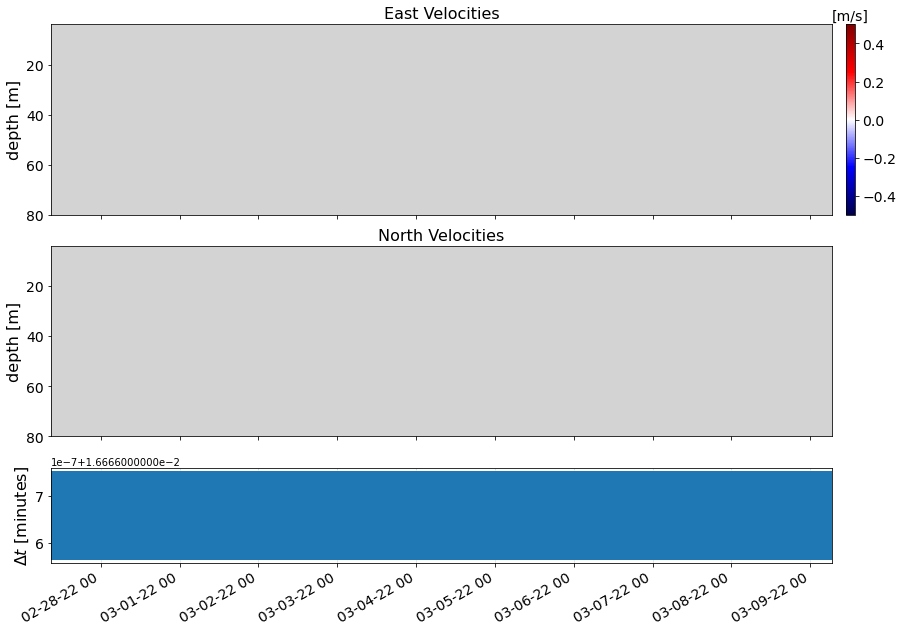

In [25]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot Motion corrected water velocities (block-averaged velocities)
# ----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import numpy as np

# create masked colormap
cm_msk = plt.get_cmap('seismic').copy()
cm_msk.set_bad(color='lightgray')

# Plot WG water velocities
yL = [4,80]
uL = 0.5
vL = 0.5
fntsz = 16
labsz = 14
ylab_str = 'depth [m]'

# Do not show vehicle heading
heights = [1,1,0.5]
nrows = 3
ncols = 1
gs_kw = dict(height_ratios=heights)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                            sharex=True,
                            sharey=False,
                            gridspec_kw=gs_kw,
                            figsize=(14, 11))


# WG: East Vel
x,y = np.meshgrid(ttbar_WG,ranges_WG)
c = ax[0].pcolormesh(x,y,Ubar_WGi,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[0].set_ylim(yL)
ax[0].set_ylabel(ylab_str,fontsize=fntsz)
ax[0].set_title('East Velocities',fontsize=fntsz)
ax[0].invert_yaxis()

# WG: North Vel
x,y = np.meshgrid(ttbar_WG,ranges_WG)
ax[1].pcolormesh(x,y,Vbar_WGi,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[1].set_ylim(yL)
ax[1].set_title('North Velocities',fontsize=fntsz)
ax[1].set_ylabel(ylab_str,fontsize=fntsz)
ax[1].invert_yaxis()

# Time gaps
ax[2].plot(tt_WG[:-1],np.diff(tt_WG)/np.timedelta64(1, 'm'))
ax[2].set_ylabel('$\Delta t$ [minutes]',fontsize=fntsz)
ax[2].grid(linestyle=':')

# rotate and align the tick labels so they look better
ax[0].tick_params(labelsize=labsz)
ax[1].tick_params(labelsize=labsz)
ax[2].tick_params(labelsize=labsz)
ax[1].set_xlim(ttbar_WG[0],ttbar_WG[-1])

# Define the date format
date_form = DateFormatter("%m-%d-%y %H")
ax[1].xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

# add a colorobar
gs = gridspec.GridSpec(ncols=3, nrows=nrows, height_ratios=gs_kw['height_ratios'], right=0.95,figure=fig)
axc = fig.add_subplot(gs[0,-1])
axc.set_visible(False)
cbar = fig.colorbar(c, ax=axc,orientation='vertical')
cax = cbar.ax
# Add label on top of colorbar.
cbar.ax.set_xlabel("[m/s]",fontsize=labsz)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=labsz)

# figure title
# tmstmp = now.strftime('%Y-%m-%d, %H:%M UTC')
# fig.suptitle(vnam + ': ADCP output ' + tmstmp, fontsize=16)
# fig.show()

/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_26216/2510834519.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0].pcolormesh(x,y,UDbar_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
/var/folders/v3/hjbc_n5s6pxb64gmhz1t6rcc0000gp/T/ipykernel_26216/2510834519.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(x,y,VDbar_WG,vmin=-vL, vmax=vL, cmap = cm_msk)


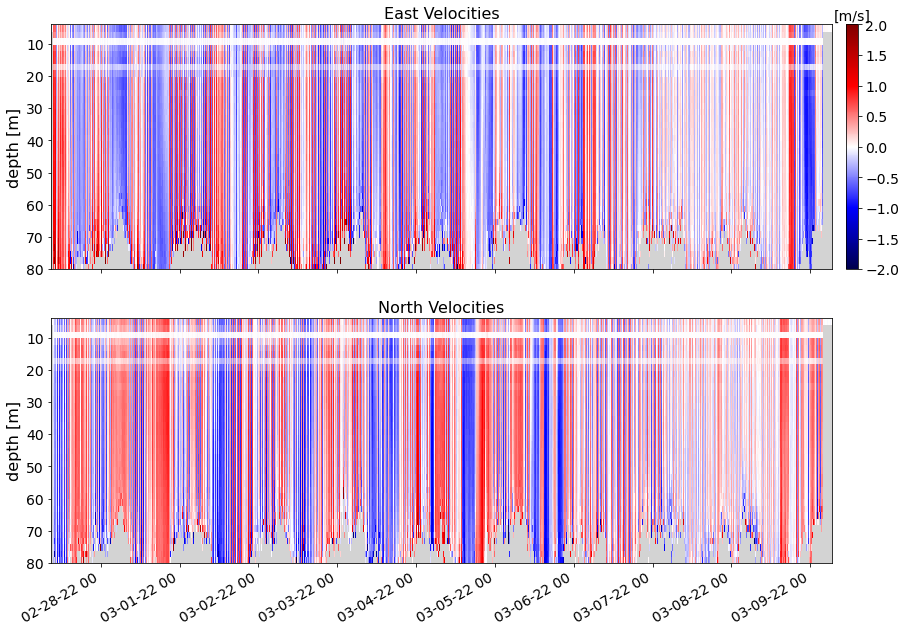

In [30]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot Doppler velocities (block-averaged velocities)
# ----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
import numpy as np

# create masked colormap
cm_msk = plt.get_cmap('seismic').copy()
cm_msk.set_bad(color='lightgray')

# Plot WG water velocities
yL = [4,80]
uL = 2.0
vL = 2.0
fntsz = 16
labsz = 14
ylab_str = 'depth [m]'

# Do not show vehicle heading
heights = [1,1]
nrows = 2
ncols = 1
gs_kw = dict(height_ratios=heights)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows,
                            sharex=True,
                            sharey=False,
                            gridspec_kw=gs_kw,
                            figsize=(14, 11))


# WG: East Vel
x,y = np.meshgrid(ttbar_WG,ranges_WG)
c = ax[0].pcolormesh(x,y,UDbar_WG,vmin=-uL, vmax=uL,cmap = cm_msk)
ax[0].set_ylim(yL)
ax[0].set_ylabel(ylab_str,fontsize=fntsz)
ax[0].set_title('East Velocities',fontsize=fntsz)
ax[0].invert_yaxis()

# WG: North Vel
x,y = np.meshgrid(ttbar_WG,ranges_WG)
ax[1].pcolormesh(x,y,VDbar_WG,vmin=-vL, vmax=vL, cmap = cm_msk)
ax[1].set_ylim(yL)
ax[1].set_title('North Velocities',fontsize=fntsz)
ax[1].set_ylabel(ylab_str,fontsize=fntsz)
ax[1].invert_yaxis()

# # Time gaps
# ax[2].plot(tt_WG[:-1],np.diff(tt_WG)/np.timedelta64(1, 'm'))
# ax[2].set_ylabel('$\Delta t$ [minutes]',fontsize=fntsz)
# ax[2].grid(linestyle=':')

# rotate and align the tick labels so they look better
ax[0].tick_params(labelsize=labsz)
ax[1].tick_params(labelsize=labsz)
# ax[2].tick_params(labelsize=labsz)
ax[1].set_xlim(ttbar_WG[0],ttbar_WG[-1])

# Define the date format
date_form = DateFormatter("%m-%d-%y %H")
ax[1].xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

# add a colorobar
gs = gridspec.GridSpec(ncols=3, nrows=nrows, height_ratios=gs_kw['height_ratios'], right=0.95,figure=fig)
axc = fig.add_subplot(gs[0,-1])
axc.set_visible(False)
cbar = fig.colorbar(c, ax=axc,orientation='vertical')
cax = cbar.ax
# Add label on top of colorbar.
cbar.ax.set_xlabel("[m/s]",fontsize=labsz)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=labsz)

# figure title
# tmstmp = now.strftime('%Y-%m-%d, %H:%M UTC')
# fig.suptitle(vnam + ': ADCP output ' + tmstmp, fontsize=16)
# fig.show()